<center> </center>

<center><font size=5 face="Helvetica" color=#306998><b>
Legume Test: BIC of Square Lattice
</b></font></center>

<center><font face="Helvetica" size=3><b>Ang Chen</b></font></center>
<center><font face="Helvetica" size=3>February, 2025</font></center>

***

In [2]:
import legume
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np

plt.rcParams["font.family"] = "Helvetica"
%matplotlib inline
%config InlineBackend.figure_format='svg'


# Define the PhC

In [3]:
n_Si3N4 = 2.02
n_SiO2 = 1.46
a = 336.

d_Si3N4 = 180./a
r = 80./a
eps_c = n_SiO2**2
eps_b = n_Si3N4**2
eps_lower, eps_upper = n_SiO2**2, n_SiO2**2 

In [4]:
lattice = legume.Lattice('square')
phc = legume.PhotCryst(lattice, eps_l=eps_lower, eps_u=eps_upper)
phc.add_layer(d=d_Si3N4, eps_b=eps_b)
phc.layers[-1].add_shape(legume.Circle(eps=eps_c, r=r, x_cent=0., y_cent=0))

gme = legume.GuidedModeExp(phc, gmax=4.5, truncate_g='abs')
npw = np.shape(gme.gvec)[1]  # number of plane waves in the expansion
print('Number of reciprocal lattice vectors in the expansion: npw = ', npw)

Number of reciprocal lattice vectors in the expansion: npw =  69


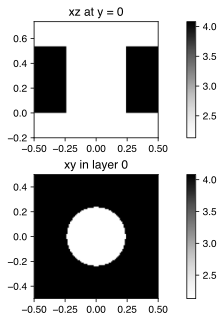

In [5]:
# Visualize what we built
legume.viz.structure(phc, xz=True, xy=True, figsize=3, Nz=300)

In [6]:
# Run the guided-mode expansion
numeig, verbose = 11, True
nk = 120
path = lattice.bz_path(['M', 'G', 'X'], [nk])

gme.run(kpoints=path['kpoints'], gmode_inds=[0, 1, 2, 3], numeig=numeig, verbose=True)
freqs = gme.freqs

nkappa, nfreq = freqs.shape[0], freqs.shape[1]
print(f'Number of wavevectros = {nkappa}, number of frequencies = {nfreq}')

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Steps in GuidedModeExp: 69 plane waves and 4 guided modes ┃ Time (s) ┃                 % vs total T ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Guided modes computation with gmode_compute='exact'       │ 9.820    │ │████████------------│   44% │
│ Inverse matrix of Fourier-space permittivity              │ 0.023    │ │--------------------│    0% │
│ Matrix diagionalization using the 'eigh' solver           │ 7.716    │ │██████--------------│   35% │
│ Creating GME matrix                                       │ 4.233    │ │███-----------------│   19% │
├───────────────────────────────────────────────────────────┼──────────┼──────────────────────────────┤
│ Total time for real part of frequencies for 241 k-points  │ 22.205   │ │████████████████████│  100% │
└───────────────────────────────────────────────────────────┴──────────┴──────────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Steps in GuidedModeExp: 69 plane waves and 4 guided modes        ┃ Time (s) ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ Total time for imaginary part of frequencies for 2651 eigenmodes │ 8.005    │
└──────────────────────────────────────────────────────────────────┴──────────┘

Number of wavevectros = 241, number of frequencies = 11


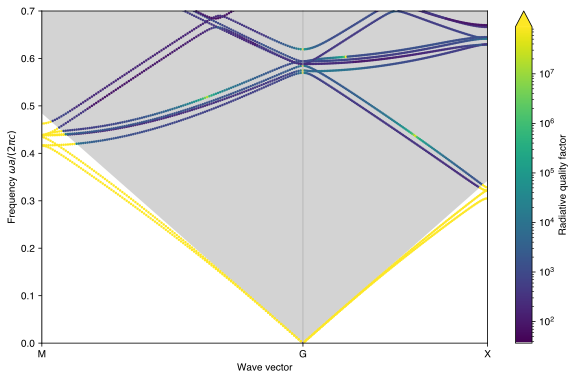

In [7]:
def plot_bands(gme):
    _, ax = plt.subplots(1, figsize = (10, 6))
    legume.viz.bands(gme, Q=True, ax=ax, cone=True, k_units=True, conecolor='lightgray',
                     markersize=2.5, markeredgecolor='none', markeredgewidth=0.5)
    ax.set_xticks(path['k_indexes'])
    ax.set_xticklabels(path['labels'])
    ax.xaxis.grid('True')
    ax.set_ylim([0., 0.7])

plot_bands(gme)

In [60]:
def plot_bands_hsu(gme):
    _, ax = plt.subplots(1, figsize = (8, 6))
    
    x = range(len(gme.freqs))
    k_parallel = np.zeros(len(x))
    gamma_index = round(1/2*len(x))
    k_parallel[:gamma_index] = np.linspace(np.sqrt(2)/2, 0, gamma_index)
    k_parallel[gamma_index-1:] = np.linspace(0, 1/2, len(x)-gamma_index+1)
    
    half_x = len(gme.freqs)//2
    _, bands_num = gme.freqs.shape
    for i in range(bands_num):
        ax.plot(x[:half_x], gme.freqs[:,i][:half_x], 'k')
        ax.plot(x[half_x+1:], gme.freqs[:,i][half_x+1:], 'k')
    

    class CustomScale(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform_non_affine(self, x):
            return np.where(x <= half_x, x * np.sqrt(2), half_x * np.sqrt(2) + (x - half_x))

        def inverted(self):
            return CustomScaleInverse()

    class CustomScaleInverse(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform_non_affine(self, x):
            # 反向变换
            return np.where(x <= half_x * np.sqrt(2), x / np.sqrt(2), half_x + (x - half_x * np.sqrt(2)))

        def inverted(self):
            return CustomScale()
    
    ax.set_xscale('function', functions=(CustomScale().transform_non_affine, CustomScaleInverse().transform_non_affine))

    ax.fill_between(x, k_parallel/n_SiO2, np.max(gme.freqs), facecolor='#F0EFA6', alpha=0.5)

    ax.set_ylim([0, .7])
    ax.set_xlim([x[0], x[-1]])

    tick_locs = [0, gamma_index, len(x) - 1]
    tick_labs = ["M", r"$\Gamma$", "X"]
    ax.set_xticks(tick_locs)
    ax.set_xticklabels(tick_labs, size=12)
    ax.set_xlabel("Wave vector", size=12)
    ax.set_ylabel(r"Frequency $\omega a/2\pi c$", size=12)
    # ax.legend(loc=3)
    # ax.grid(True, color="black", linestyle="--", alpha=0.5)
    for x in tick_locs:
        ax.axvline(x, color="gray", lw=2)

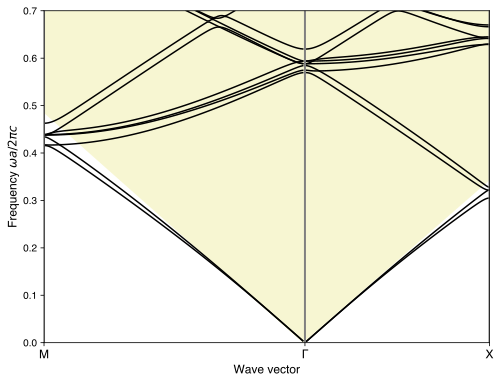

In [61]:
plot_bands_hsu(gme)